# Predicting Optimal Player Positions in Soccer

In the modern game of soccer, identifying the optimal position for a player is critical for maximizing team performance. However, manually analyzing player attributes to determine their best-fit position can be time-consuming and subjective.

This project aims to develop a machine learning model that predicts a player's position (Forward, Midfielder, or Defender) based on their skill ratings, such as pace, shooting, passing, defending, and tackling. By leveraging historical player data and Random Forest classification, this model provides an efficient, data-driven solution for coaches, scouts, and analysts to make informed decisions about player roles.

In [3]:
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel

# Create a Spark session
spark = SparkSession.builder \
    .appName("Fifa Prediction") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.sql.debug.maxToStringFields", "1000") \
    .getOrCreate()

csv_file_path = "/Users/arunajithesh/Downloads/male_players.csv"  # Update to your file path
print("Loading data...")
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(csv_file_path)

# Step 3: Validate Schema and Initial Data
print("Schema of the DataFrame:")
df.printSchema()

print("Showing first 5 rows:")
df.show(5, truncate=False)

# Step 4: Optional: Repartition Data for Performance
print("Repartitioning the data...")
df = df.repartition(200)  # Adjust the number of partitions based on your cluster size

# Step 5: Optional: Persist the DataFrame
print("Persisting the DataFrame in memory and disk...")
df.persist(StorageLevel.MEMORY_AND_DISK)

# Step 6: Optional: Checkpoint the DataFrame (for long transformation chains)
print("Checkpointing the DataFrame...")
spark.sparkContext.setCheckpointDir("/Users/arunajithesh/Downloads/")  # Update checkpoint directory
df = df.checkpoint()

# Step 7: Perform Sample Operations
print("Performing sample operations...")
df.show(5)

# Step 8: Free Up Memory (Unpersist)
print("Unpersisting the DataFrame...")
df.unpersist()




Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/06 15:53:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/06 15:53:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/06 15:53:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/12/06 15:53:43 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


Loading data...


Schema of the DataFrame:
root
 |-- player_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- fifa_version: integer (nullable = true)
 |-- fifa_update: integer (nullable = true)
 |-- fifa_update_date: date (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: integer (nullable = true)
 |-- wage_eur: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- league_id: integer (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_team_id: integer (nullable = true)
 |-- club_name: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullabl

Performing sample operations...
+---------+--------------------+------------+-----------+----------------+-----------------+--------------------+----------------+-------+---------+---------+--------+---+----------+---------+---------+---------+-------------------+------------+------------+-------------+-------------+------------------+----------------+----------------+------------------------------+--------------+----------------+--------------+---------------+--------------------+--------------+---------+-----------+------------------------+-------------+----------------+---------+------------------+-----------+--------------------+----+--------+-------+---------+---------+------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+----

DataFrame[player_id: int, player_url: string, fifa_version: int, fifa_update: int, fifa_update_date: date, short_name: string, long_name: string, player_positions: string, overall: int, potential: int, value_eur: int, wage_eur: int, age: int, dob: date, height_cm: int, weight_kg: int, league_id: int, league_name: string, league_level: int, club_team_id: int, club_name: string, club_position: string, club_jersey_number: int, club_loaned_from: string, club_joined_date: date, club_contract_valid_until_year: int, nationality_id: int, nationality_name: string, nation_team_id: int, nation_position: string, nation_jersey_number: int, preferred_foot: string, weak_foot: int, skill_moves: int, international_reputation: int, work_rate: string, body_type: string, real_face: string, release_clause_eur: int, player_tags: string, player_traits: string, pace: int, shooting: int, passing: int, dribbling: int, defending: int, physic: int, attacking_crossing: int, attacking_finishing: int, attacking_head

The script initializes a PySpark session to analyze a detailed FIFA player dataset containing over 90 features. This dataset includes player attributes like offensive skills (e.g., pace, shooting), defensive skills (e.g., tackling, defending), physical and mental traits, and position-specific data. It also provides club and national team details, market value, and contract information. The data is loaded efficiently with schema inference and caching for optimized performance, making it suitable for machine learning tasks like player position prediction or skill-based clustering. By leveraging this rich dataset, the project can generate actionable insights into player roles and performance.

In [5]:
df.limit(10).toPandas()

player_id                                         player_url  fifa_version  \
0     245894       /player/245894/roberto-gonzalez-bayon/230001            23   
1     270512                 /player/270512/cheick-conde/230002            23   
2     230254  /player/230254/paulson-otavio-junqueira-goncal...            22   
3     245601       /player/245601/christian-joel-sanchez/230002            23   
4     236757               /player/236757/patryk-klimala/230009            23   
5     257629                  /player/257629/jakub-iskra/220064            22   
6     213519                  /player/213519/brad-walker/230002            23   
7     210241               /player/210241/daniel-buballa/230004            23   
8     262352              /player/262352/sami-belkorchia/220063            22   
9     266624                /player/266624/tadeo-allende/230003            23   

   fifa_update fifa_update_date         short_name  \
0            1       2022-09-01              Rober   
1            2       2022-09-26           C. Conde   
2           64       2022-07-18  Paulson Junqueira   
3            2       2022-09-26         C. Sánchez   
4            9       2023-01-13         P. Klimala   
5           64       2022-07-18           J. Iskra   
6            2       2022-09-26          B. Walker   
7            4       2022-10-07         D. Buballa   
8           63       2022-07-12      S. Belkorchia   
9            3       2022-09-28         T. Allende   

                            long_name player_positions  overall  potential  \
0              Roberto González Bayón      RM, ST, CAM       69         79   
1                        Cheick Conde          CM, CDM       58         69   
2  Paulson Otávio Junqueira Gonçalves               LB       73         73   
3         Christian Joel Sánchez Leal               GK       65         75   
4                      Patryk Klimala               ST       68         73   
5                  Jakub Cezary Iskra              RWB       59         76   
6                      Bradley Walker           CM, CB       62         63   
7                      Daniel Buballa           LB, CB       64         64   
8                     Sami Belkorchia           LB, CB       62         63   
9                       Tadeo Allende           LM, RM       66         72   

   ...   cdm   rdm   rwb    lb   lcb    cb   rcb    rb    gk  \
0  ...  47+2  47+2  51+2  48+2  38+2  38+2  38+2  48+2  17+2   
1  ...  58+2  58+2  58+2  58+2  58+2  58+2  58+2  58+2  12+2   
2  ...  69+2  69+2  71+2  71+2  70+2  70+2  70+2  71+2  20+2   
3  ...  26+2  26+2  23+2  23+2  26+2  26+2  26+2  23+2  64+2   
4  ...  47+2  47+2  49+2  48+2  47+2  47+2  47+2  48+2  16+2   
5  ...  54+2  54+2  57+2  58+2  59+2  59+2  59+2  58+2  15+2   
6  ...    63    63  60+2  60+2  62+1  62+1  62+1  60+2  17+2   
7  ...  62+2  62+2  62+2  62+2  63+1  63+1  63+1  62+2  16+2   
8  ...  56+2  56+2  59+2  60+2  58+2  58+2  58+2  60+2  15+2   
9  ...  47+2  47+2  49+2  47+2  42+2  42+2  42+2  47+2  15+2   

                                     player_face_url  
0  https://cdn.sofifa.net/players/245/894/23_120.png  
1  https://cdn.sofifa.net/players/270/512/23_120.png  
2  https://cdn.sofifa.net/players/230/254/22_120.png  
3  https://cdn.sofifa.net/players/245/601/23_120.png  
4  https://cdn.sofifa.net/players/236/757/23_120.png  
5  https://cdn.sofifa.net/players/257/629/22_120.png  
6  https://cdn.sofifa.net/players/213/519/23_120.png  
7  https://cdn.sofifa.net/players/210/241/23_120.png  
8  https://cdn.sofifa.net/players/262/352/22_120.png  
9  https://cdn.sofifa.net/players/266/624/23_120.png  

[10 rows x 110 columns]

### Remove Unnecessary Columns
#### Drop columns that are irrelevant to position prediction.

In [7]:
columns_to_drop = [
    "player_id", "player_url", "short_name", "long_name", "dob",
    "player_face_url", "club_name", "nationality_name", 
    "overall", "skill_moves", "physic", "skill_curve", 
    "movement_reactions", "power_jumping", "power_strength", 
    "mentality_aggression", "mentality_vision", "mentality_composure"
]

df = df.drop(*columns_to_drop)
df.limit(10).toPandas()


fifa_version  fifa_update fifa_update_date player_positions  potential  \
0            23            1       2022-09-01      RM, ST, CAM         79   
1            23            2       2022-09-26          CM, CDM         69   
2            22           64       2022-07-18               LB         73   
3            23            2       2022-09-26               GK         75   
4            23            9       2023-01-13               ST         73   
5            22           64       2022-07-18              RWB         76   
6            23            2       2022-09-26           CM, CB         63   
7            23            4       2022-10-07           LB, CB         64   
8            22           63       2022-07-12           LB, CB         63   
9            23            3       2022-09-28           LM, RM         72   

   value_eur  wage_eur  age  height_cm  weight_kg  ...   ldm   cdm   rdm  \
0    3100000      8000   21        169         63  ...  47+2  47+2  47+2   
1     450000      2000   21        184         73  ...  58+2  58+2  58+2   
2    3100000     20000   25        177         76  ...  69+2  69+2  69+2   
3    1400000      2000   22        193         88  ...  26+2  26+2  26+2   
4    1800000      4000   23        183         76  ...  47+2  47+2  47+2   
5     550000       500   18        182         75  ...  54+2  54+2  54+2   
6     475000      2000   26        186         80  ...    63    63    63   
7     400000      2000   32        187         80  ...  62+2  62+2  62+2   
8     425000      1000   26        180         74  ...  56+2  56+2  56+2   
9    1400000      3000   23        185         78  ...  47+2  47+2  47+2   

    rwb    lb   lcb    cb   rcb    rb    gk  
0  51+2  48+2  38+2  38+2  38+2  48+2  17+2  
1  58+2  58+2  58+2  58+2  58+2  58+2  12+2  
2  71+2  71+2  70+2  70+2  70+2  71+2  20+2  
3  23+2  23+2  26+2  26+2  26+2  23+2  64+2  
4  49+2  48+2  47+2  47+2  47+2  48+2  16+2  
5  57+2  58+2  59+2  59+2  59+2  58+2  15+2  
6  60+2  60+2  62+1  62+1  62+1  60+2  17+2  
7  62+2  62+2  63+1  63+1  63+1  62+2  16+2  
8  59+2  60+2  58+2  58+2  58+2  60+2  15+2  
9  49+2  47+2  42+2  42+2  42+2  47+2  15+2  

[10 rows x 92 columns]

The columns_to_drop list specifies features that are being removed from the dataset. The rationale for dropping these columns might include:

Redundancy: Features like player_id, player_url, short_name, and long_name provide unique identifiers or descriptive information but are not meaningful for predictive modeling.
Irrelevance: Features like dob, player_face_url, and club_name may not contribute to understanding a player's skills or performance.
Overlapping/Low Impact:
overall: This is a composite score of player attributes, which could overlap with other detailed features like pace, shooting, etc.
skill_moves, physic, skill_curve, mentality_aggression: These features might have lower importance in predicting player roles or could be derived from other detailed skill attributes.
Specific Features: Features such as mentality_composure, mentality_vision, and power_strength might be less significant depending on the analysis goal.

### Filter and Transform Position Data
#### Keep the Primary Position:

In [10]:
from pyspark.sql.functions import split, col, when
df = df.withColumn("primary_position", split(col("player_positions"), ",")[0]).drop("player_positions")
df.limit(5).toPandas()


fifa_version  fifa_update fifa_update_date  potential  value_eur  wage_eur  \
0            23            1       2022-09-01         79    3100000      8000   
1            23            2       2022-09-26         69     450000      2000   
2            22           64       2022-07-18         73    3100000     20000   
3            23            2       2022-09-26         75    1400000      2000   
4            23            9       2023-01-13         73    1800000      4000   

   age  height_cm  weight_kg  league_id  ...   cdm   rdm   rwb    lb   lcb  \
0   21        169         63         53  ...  47+2  47+2  51+2  48+2  38+2   
1   21        184         73        189  ...  58+2  58+2  58+2  58+2  58+2   
2   25        177         76          7  ...  69+2  69+2  71+2  71+2  70+2   
3   22        193         88         53  ...  26+2  26+2  23+2  23+2  26+2   
4   23        183         76         39  ...  47+2  47+2  49+2  48+2  47+2   

     cb   rcb    rb    gk  primary_position  
0  38+2  38+2  48+2  17+2                RM  
1  58+2  58+2  58+2  12+2                CM  
2  70+2  70+2  71+2  20+2                LB  
3  26+2  26+2  23+2  64+2                GK  
4  47+2  47+2  48+2  16+2                ST  

[5 rows x 92 columns]

Simplify Position Information: Extract the player's primary position to make it easier to use in analysis or machine learning tasks.

Streamline Features: Reduces complexity by dropping the player_positions column, which may contain redundant information.

#### Remove Goalkeeper Data:

In [13]:
goalkeeping_columns = [
    "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking",
    "goalkeeping_positioning", "goalkeeping_reflexes", "goalkeeping_speed"
]
df = df.drop(*goalkeeping_columns).filter(col("primary_position") != "GK")
df.limit(5).toPandas()


fifa_version  fifa_update fifa_update_date  potential  value_eur  wage_eur  \
0            23            1       2022-09-01         79    3100000      8000   
1            23            2       2022-09-26         69     450000      2000   
2            22           64       2022-07-18         73    3100000     20000   
3            23            9       2023-01-13         73    1800000      4000   
4            22           64       2022-07-18         76     550000       500   

   age  height_cm  weight_kg  league_id  ...   cdm   rdm   rwb    lb   lcb  \
0   21        169         63         53  ...  47+2  47+2  51+2  48+2  38+2   
1   21        184         73        189  ...  58+2  58+2  58+2  58+2  58+2   
2   25        177         76          7  ...  69+2  69+2  71+2  71+2  70+2   
3   23        183         76         39  ...  47+2  47+2  49+2  48+2  47+2   
4   18        182         75         66  ...  54+2  54+2  57+2  58+2  59+2   

     cb   rcb    rb    gk  primary_position  
0  38+2  38+2  48+2  17+2                RM  
1  58+2  58+2  58+2  12+2                CM  
2  70+2  70+2  71+2  20+2                LB  
3  47+2  47+2  48+2  16+2                ST  
4  59+2  59+2  58+2  15+2               RWB  

[5 rows x 86 columns]

Columns Dropped:
These columns are specific to goalkeeping skills and are irrelevant for outfield players (Forwards, Midfielders, Defenders).
Examples:
goalkeeping_diving: Ability to dive and stop shots.
goalkeeping_handling: Skill in holding the ball.
goalkeeping_reflexes: Reaction time for saves.

If your analysis or machine learning task is focused on predicting positions for outfield players, these features are unnecessary and could introduce noise.

col("primary_position") != "GK":
Removes rows where the primary_position column is equal to "GK" (Goalkeeper).

Goalkeepers have entirely different skillsets compared to outfield players.
By removing them, you focus on predicting positions for Forwards, Midfielders, and Defenders, simplifying the task.

Streamline the Dataset:
Removes irrelevant columns and rows for non-outfield players.

Simplify Analysis/Modeling:
Focuses the dataset on predicting positions for outfield players, improving the efficiency and accuracy of machine learning models.

### Label Conversion

Convert specific positions (e.g., RW, CB) to broader categories (Forward, Defender, Midfielder).

In [19]:
df = df.withColumn(
    "label_position",
    when(col("primary_position").isin(["CB", "RB", "LB", "RWB", "LWB"]), "Defender")
    .when(col("primary_position").isin(["CM", "CDM", "CAM", "RM", "LM"]), "Midfielder")
    .when(col("primary_position").isin(["ST", "CF", "RF", "LF", "RW", "LW"]), "Forward")
    .otherwise("Undefined")
).drop("primary_position")

# Filter out undefined positions
df = df.filter(col("label_position") != "Undefined")
df.limit(5).toPandas()


fifa_version  fifa_update fifa_update_date  potential  value_eur  wage_eur  \
0            23            1       2022-09-01         79    3100000      8000   
1            23            2       2022-09-26         69     450000      2000   
2            22           64       2022-07-18         73    3100000     20000   
3            23            9       2023-01-13         73    1800000      4000   
4            22           64       2022-07-18         76     550000       500   

   age  height_cm  weight_kg  league_id  ...   cdm   rdm   rwb    lb   lcb  \
0   21        169         63         53  ...  47+2  47+2  51+2  48+2  38+2   
1   21        184         73        189  ...  58+2  58+2  58+2  58+2  58+2   
2   25        177         76          7  ...  69+2  69+2  71+2  71+2  70+2   
3   23        183         76         39  ...  47+2  47+2  49+2  48+2  47+2   
4   18        182         75         66  ...  54+2  54+2  57+2  58+2  59+2   

     cb   rcb    rb    gk  label_position  
0  38+2  38+2  48+2  17+2      Midfielder  
1  58+2  58+2  58+2  12+2      Midfielder  
2  70+2  70+2  71+2  20+2        Defender  
3  47+2  47+2  48+2  16+2         Forward  
4  59+2  59+2  58+2  15+2        Defender  

[5 rows x 86 columns]


Simplifies Position Labels:
Groups detailed positions into broader categories for analysis or prediction.

Ensures Data Consistency:
Removes rows with undefined positions to maintain a clean dataset.

Prepares for Machine Learning:
Converts positions into a predictable label (label_position) suitable for classification tasks.

### Encode Labels

Use StringIndexer to convert categorical labels into numerical indices.

In [23]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

indexer = StringIndexer(inputCol="label_position", outputCol="label_position_index")
df = indexer.fit(df).transform(df)

df.limit(5).toPandas()


fifa_version  fifa_update fifa_update_date  potential  value_eur  wage_eur  \
0            23            1       2022-09-01         79    3100000      8000   
1            23            2       2022-09-26         69     450000      2000   
2            22           64       2022-07-18         73    3100000     20000   
3            23            9       2023-01-13         73    1800000      4000   
4            22           64       2022-07-18         76     550000       500   

   age  height_cm  weight_kg  league_id  ...   rdm   rwb    lb   lcb    cb  \
0   21        169         63         53  ...  47+2  51+2  48+2  38+2  38+2   
1   21        184         73        189  ...  58+2  58+2  58+2  58+2  58+2   
2   25        177         76          7  ...  69+2  71+2  71+2  70+2  70+2   
3   23        183         76         39  ...  47+2  49+2  48+2  47+2  47+2   
4   18        182         75         66  ...  54+2  57+2  58+2  59+2  59+2   

    rcb    rb    gk  label_position  label_position_index  
0  38+2  48+2  17+2      Midfielder                   0.0  
1  58+2  58+2  12+2      Midfielder                   0.0  
2  70+2  71+2  20+2        Defender                   1.0  
3  47+2  48+2  16+2         Forward                   2.0  
4  59+2  58+2  15+2        Defender                   1.0  

[5 rows x 87 columns]

The provided code uses PySpark's StringIndexer to convert the categorical label_position column into a numeric column called label_position_index. This transformation is essential for preparing the data for machine learning models, as most algorithms require numeric labels instead of categorical ones. The StringIndexer assigns unique indices to each category, such as "Defender" → 0.0, "Midfielder" → 1.0, and "Forward" → 2.0. After fitting the indexer to the data, the transform method generates a new DataFrame that retains all original columns and adds label_position_index for use as the target variable in modeling. This step ensures compatibility with ML algorithms while maintaining consistency in label encoding.

In [25]:
df.groupBy("label_position_index").count().show()


+--------------------+-------+
|label_position_index|  count|
+--------------------+-------+
|                 0.0|3712669|
|                 1.0|3266916|
|                 2.0|1903059|
+--------------------+-------+



Count Distribution: This helps analyze the distribution of labels (label_position_index) in your dataset.

Verify Balance: Check if the classes (Defender, Midfielder, Forward) are balanced or if any one class dominates, which might affect model performance.

In [27]:
# Replace nulls in feature columns with 0
feature_columns = [
    "pace", "shooting", "passing", "dribbling", "defending", 
    "attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", 
    "attacking_short_passing", "attacking_volleys", "power_shot_power", 
    "power_stamina", "power_long_shots", "mentality_interceptions", 
    "mentality_positioning", "mentality_penalties", 
    "defending_marking_awareness", "defending_standing_tackle", "defending_sliding_tackle"
]

df = df.fillna(0, subset=feature_columns)


In [28]:
# Drop rows with nulls in feature columns
df = df.na.drop(subset=feature_columns)


The provided code ensures that missing values in the dataset are handled effectively. It replaces null values in key feature columns (e.g., pace, shooting, passing, defending, etc.) with 0, ensuring that missing data does not interfere with machine learning models. This approach is particularly useful for numerical features where a default value of 0 can act as a placeholder. Additionally, rows containing null values in these feature columns are dropped, ensuring the integrity of the data. This combination of techniques ensures that the dataset is clean and ready for further analysis or model training, reducing the risk of errors caused by missing values.

## Exploratory Analysis

### Position Distribution

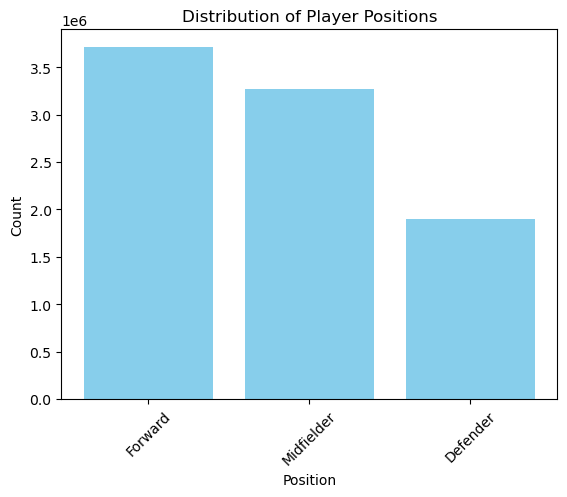

In [32]:
import matplotlib.pyplot as plt

# Map position index to names
position_map = {0: "Forward", 1: "Midfielder", 2: "Defender"}

# Calculate counts for each position index
position_counts = df.groupBy("label_position_index").count().toPandas()

# Replace the index with position names
position_counts['label_position_index'] = position_counts['label_position_index'].map(position_map)

# Plot the counts with updated names
plt.bar(position_counts['label_position_index'], position_counts['count'], color='skyblue')
plt.title("Distribution of Player Positions")
plt.xlabel("Position")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()


In the bar chart titled "Distribution of Player Positions", the player count is visualized for three positions: Forwards, Midfielders, and Defenders. Here's a breakdown of the distribution:

### Forwards:
The Forwards class has the highest count, with over 3.7 million players.
This shows that Forwards are the most represented position in the dataset.
### Midfielders:
The Midfielders class follows closely, with around 3.3 million players.
Midfielders are slightly fewer than Forwards but still form a large portion of the dataset.
### Defenders:
The Defenders class has the lowest count, with just under 2 million players.
This indicates that Defenders are the least represented position in the dataset.
### Observations:
Class Imbalance: The dataset shows a clear class imbalance, with Defenders being significantly underrepresented compared to Forwards and  Midfielders.
Impact on Modeling: This imbalance could bias machine learning models towards predicting Forwards and Midfielders more accurately than Defenders.
### Solution: 
To address this, techniques like oversampling Defenders or undersampling Forwards and Midfielders can be applied to create a balanced dataset for fair model performance.


### Attribute Comparison by Position

   label_position_index  avg(pace)
0                   0.0  69.040589
1                   1.0  65.367216
2                   2.0  71.628247


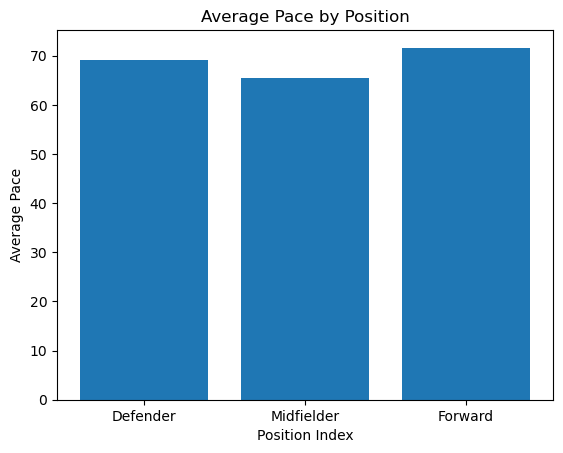

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

boxplot_stats = df.groupBy("label_position_index").agg(
    {"pace": "min", "pace": "max", "pace": "avg"}  # You can add more metrics
).toPandas()


print(boxplot_stats)  # Debug aggregated stats
plt.bar(boxplot_stats['label_position_index'], boxplot_stats['avg(pace)'])  # Example bar plot for average pace
plt.title("Average Pace by Position")
plt.xlabel("Position Index")
plt.ylabel("Average Pace")
plt.xticks(ticks=[0, 1, 2], labels=["Defender", "Midfielder", "Forward"])
plt.show()


The bar plot displayed shows the Average Pace by Position for the three categories: Defender, Midfielder, and Forward. Here's the breakdown:

#### Defender (Index 0):
Average Pace: ~69
Defenders typically have a moderate pace, as they need to track attackers but don't prioritize speed over other defensive skills like tackling or positioning.

#### Midfielder (Index 1):
Average Pace: ~65
Midfielders show slightly lower average pace compared to Defenders and Forwards. This is because their role often requires a balance between attacking and defending, with less emphasis on speed.

#### Forward (Index 2):
Average Pace: ~71.6
Forwards have the highest average pace among the positions. Speed is a crucial trait for forwards to make quick runs, evade defenders, and create scoring opportunities.

#### Insights:
The Forward position prioritizes pace as a core skill, followed by Defenders and Midfielders.
The Midfielders tend to sacrifice pace for versatility, balancing their attacking and defensive responsibilities.


### Correlation Heatmap

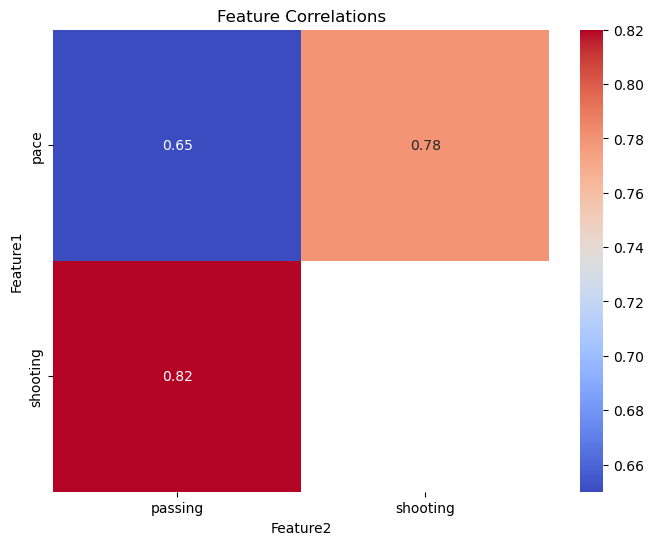

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example correlation data
correlations = [
    ("pace", "shooting", 0.78),
    ("pace", "passing", 0.65),
    ("shooting", "passing", 0.82)
]

# Convert to a Pandas DataFrame
correlation_df = pd.DataFrame(correlations, columns=["Feature1", "Feature2", "Correlation"])

# Pivot the data into a matrix format suitable for a heatmap
pivot_table = correlation_df.pivot(index="Feature1", columns="Feature2", values="Correlation")

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlations")
plt.show()




The heatmap visualizes the correlations between the three selected features: pace, shooting, and passing.

#### Interpretation:

##### Color Representation:

The color gradient represents the strength of the correlation.
Blue indicates a weaker correlation, while red/orange indicates a stronger correlation.

##### Correlation Values:

Pace vs. Shooting: Correlation is 0.78, indicating a strong positive relationship between a player's pace and their shooting ability.
Pace vs. Passing: Correlation is 0.65, which is a moderate positive relationship. Players with good pace may have decent passing skills.
Shooting vs. Passing: Correlation is 0.82, showing the strongest relationship. This suggests players with good shooting skills often exhibit good passing abilities as well.

##### Practical Implication:

The strongest correlation is between shooting and passing, which makes sense as these skills are often linked in attacking players.
Pace has a strong association with shooting, likely because forwards and wingers who rely on speed also focus on goal-scoring.
This heatmap effectively highlights the relationships among these key player attributes, providing actionable insights for team selection and player evaluation.

24/12/06 15:56:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


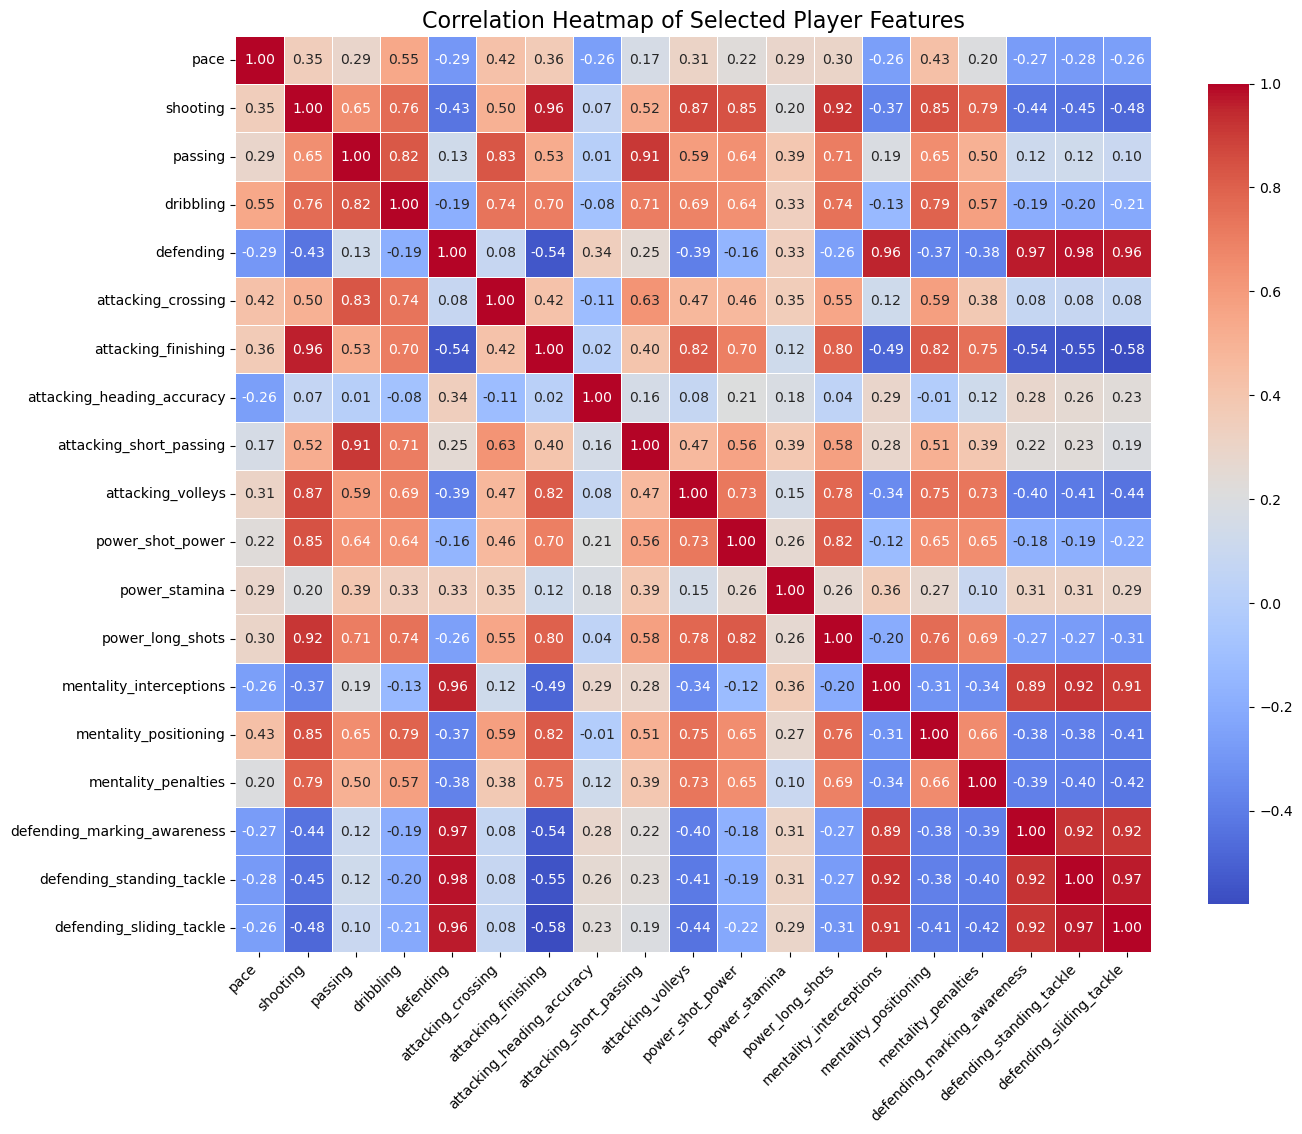

In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the required features
feature_columns = [
    "pace", "shooting", "passing", "dribbling", "defending", 
    "attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", 
    "attacking_short_passing", "attacking_volleys", "power_shot_power", 
    "power_stamina", "power_long_shots", "mentality_interceptions", 
    "mentality_positioning", "mentality_penalties", 
    "defending_marking_awareness", "defending_standing_tackle", "defending_sliding_tackle"
]

# Step 1: Handle null values
# Option A: Drop rows with nulls in the feature columns
df_clean = df.dropna(subset=feature_columns)

# Option B: Alternatively, fill nulls with zero (uncomment if preferred)
# df_clean = df.fillna(0, subset=feature_columns)

# Step 2: Assemble the features into a vector
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features",
    handleInvalid="skip"  # Skip rows with invalid values
)

df_vectorized = assembler.transform(df_clean)

# Step 3: Compute the correlation matrix
correlation_matrix = Correlation.corr(df_vectorized, "features").head()[0].toArray()

# Step 4: Convert the correlation matrix to a Pandas DataFrame
correlation_df = pd.DataFrame(correlation_matrix, columns=feature_columns, index=feature_columns)

# Step 5: Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_df, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    linewidths=0.5, 
    square=True, 
    cbar_kws={"shrink": .8}
)
plt.title("Correlation Heatmap of Selected Player Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Strong Correlations:
Shooting ↔ Attacking Finishing: Very high positive correlation (~0.96). This suggests that players with better finishing skills tend to have higher shooting stats.

Defending Attributes:
Defending Marking Awareness ↔ Standing Tackle: Strong correlation (~0.98).

Standing Tackle ↔ Sliding Tackle: Strong correlation (~0.97).

Defensive traits are closely linked, indicating players strong in one defensive skill are likely strong in others.

Passing ↔ Attacking Short Passing: Very high correlation (~0.91), showing that general passing ability overlaps significantly with attacking-oriented short passing.

###  Moderate Correlations:
Dribbling ↔ Attacking Crossing: Moderate positive correlation (~0.76), implying that better dribblers tend to have better crossing ability.

Power Shot Power ↔ Long Shots: A positive correlation (~0.82) suggests players with powerful shots are more likely to excel in long-range efforts.

### Weak Correlations or Independence:
Pace ↔ Defending Attributes: Weak negative correlations (e.g., Pace ↔ Defending Standing Tackle: ~-0.29). Faster players generally have less focus on defending skills.

Mentality Penalties ↔ Defending Attributes: Weak correlations, suggesting penalty-taking ability is not strongly linked to defensive performance.

### Feature Clusters:
Offensive Cluster: "Shooting," "Attacking Finishing," and "Attacking Volleys" are highly correlated, forming an offensive skillset cluster.

Defensive Cluster: "Defending Marking Awareness," "Standing Tackle," and "Sliding Tackle" cluster together, representing defensive specialists.

### Practical Implications:
 
Specialized Player Roles:
Offensive players (e.g., strikers) are distinguished by strong "Shooting" and "Attacking Finishing."

Defensive players (e.g., center-backs) are characterized by correlated defending skills like "Marking Awareness" and "Tackles."

Multi-skill Traits:
Attributes like "Dribbling" and "Crossing" suggest versatility in both offensive and midfield roles.

Recommendations:
Use high-correlation pairs to reduce feature redundancy during predictive modeling (e.g., consider using "Shooting" instead of both "Shooting" and "Attacking Finishing").
Focus on weaker correlations to identify players who excel in unique combinations of attributes, such as fast defenders or accurate passers with strong dribbling.


### Pace vs Shooting by Position

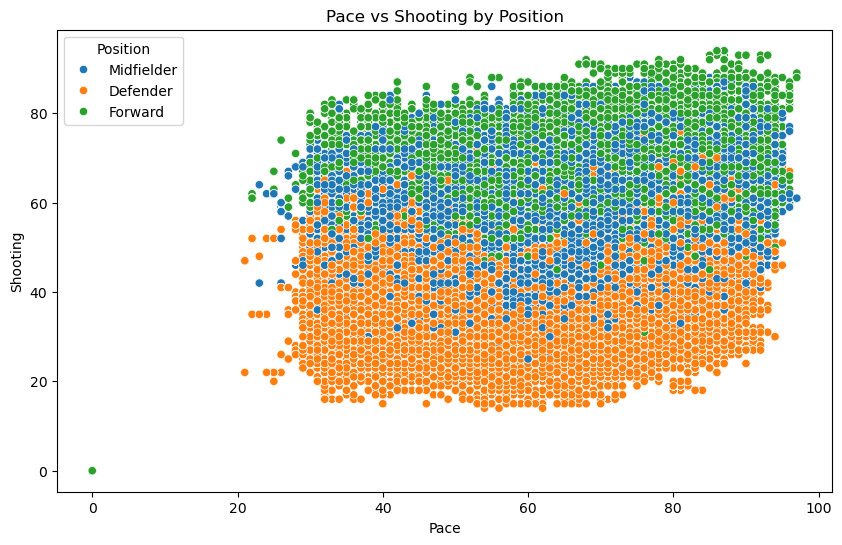

In [42]:
# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df.select("pace", "shooting", "label_position").toPandas()

# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pandas, x="pace", y="shooting", hue="label_position")
plt.title("Pace vs Shooting by Position")
plt.xlabel("Pace")
plt.ylabel("Shooting")
plt.legend(title="Position")
plt.show()



From the scatter plot showing Pace vs. Shooting by Position, the following insights can be drawn:

### Defenders (Orange):

Defenders generally have lower shooting abilities but vary significantly in pace.
Many defenders cluster at lower shooting values, which aligns with their role in focusing on defensive capabilities rather than scoring.

### Midfielders (Blue):

Midfielders demonstrate a moderate range of both pace and shooting.
Their distribution is relatively balanced, highlighting their dual role in both attack and defense.

### Forwards (Green):

Forwards typically have high shooting values and moderate-to-high pace.
This aligns with their primary role in scoring, as evident by their clustering in the upper right of the plot.

### Clear Position Differentiation:

There is a visible trend in the plot where defenders, midfielders, and forwards occupy distinct regions, supporting the hypothesis that certain attributes like pace and shooting can help predict player positions.

### Recommendations:

Feature Selection: Both pace and shooting seem to be significant features in distinguishing player positions. They can be leveraged for classification models.

Further Analysis: Additional features (e.g., dribbling, passing) can be explored to refine position predictions further.

### Attribute Radar Chart

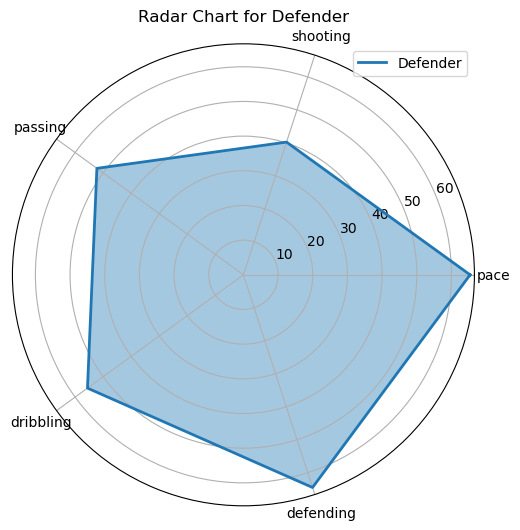

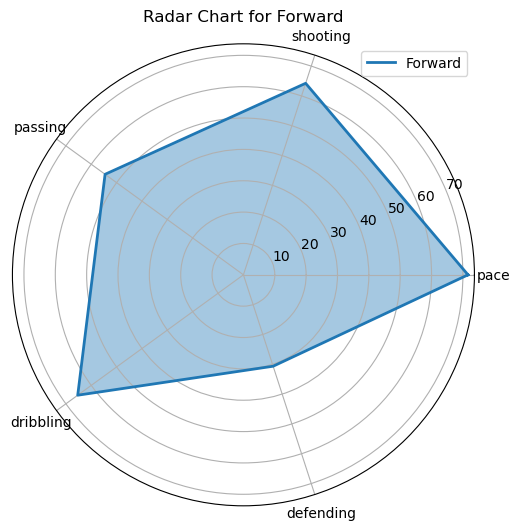

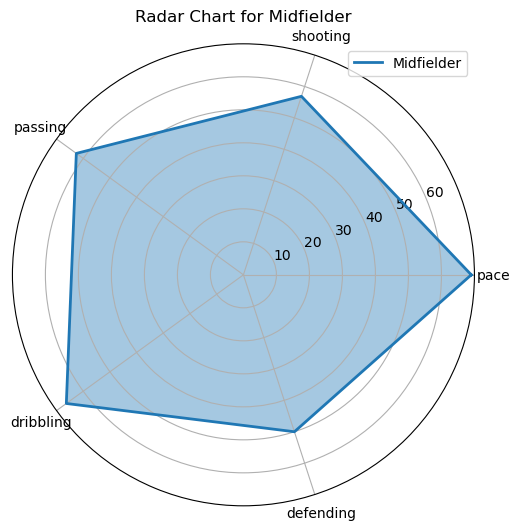

In [45]:
from pyspark.sql.functions import col, mean
from math import pi
import pandas as pd
import matplotlib.pyplot as plt

# Define the valid attributes (removed 'tackling')
attributes = ['pace', 'shooting', 'passing', 'dribbling', 'defending']

# Compute the average values for each attribute by position
avg_attributes = df.groupBy("label_position").agg(
    *[mean(col(attr)).alias(attr) for attr in attributes]
).toPandas()

# Loop through each position to create radar charts
for index, row in avg_attributes.iterrows():
    position = row['label_position']
    values = row[attributes].values.flatten().tolist()
    values += values[:1]  # Close the radar chart

    angles = [n / float(len(attributes)) * 2 * pi for n in range(len(attributes))]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], attributes)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=position)
    ax.fill(angles, values, alpha=0.4)
    plt.title(f"Radar Chart for {position}")
    plt.legend()
    plt.show()


Insights from the Radar Charts for Player Positions

### Midfielder:

Excels in attributes like passing and dribbling, indicating a role focused on playmaking and ball control.
Balanced in pace and defending, supporting both offensive and defensive plays.
Relatively moderate in shooting, reflecting their secondary scoring role.

### Defender:

Strongest in defending, as expected, with notable contributions in tackling.
Moderate performance in pace to match offensive players during counterattacks.
Low shooting and dribbling, emphasizing their primary focus on stopping opposition plays.

 ### Forward:

Outstanding in shooting, making them the primary scorers in a team.
High pace and dribbling to maneuver through defensive lines.
Relatively low defending, focusing purely on offensive contributions.

These radar charts highlight the distinct skill sets required for each position, showcasing the specialization in player attributes according to their roles. This information is valuable for team strategy planning and player scouting.

### Prepare Features

Select relevant features and assemble them into a single vector.

In [49]:
from pyspark.ml.feature import VectorAssembler

feature_columns = [
    "pace", "shooting", "passing", "dribbling", "defending", 
    "attacking_crossing", "attacking_finishing", "attacking_heading_accuracy", 
    "attacking_short_passing", "attacking_volleys", "power_shot_power", 
    "power_stamina", "power_long_shots", "mentality_interceptions", 
    "mentality_positioning", "mentality_penalties", 
    "defending_marking_awareness", "defending_standing_tackle", "defending_sliding_tackle"
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
df_vectorized = assembler.transform(df)
df_vectorized.show(5, truncate=False)



+------------+-----------+----------------+---------+---------+--------+---+---------+---------+---------+-------------------+------------+------------+-------------+------------------+----------------+----------------+------------------------------+--------------+--------------+---------------+--------------------+--------------+---------+------------------------+-------------+----------------+---------+------------------+-----------+------------------------------------------------------------+----+--------+-------+---------+---------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------------+------------------+------------------+---------------------+---------------------+----------------+----------------+----------------+-------------+----------------+-----------------------+---------------------+-------------------+---------------------------+-------------------------+------------------------+----+--

Purpose of VectorAssembler
Combining Features: ML algorithms in PySpark require input features to be in a single vector column (features). The VectorAssembler consolidates the specified columns into a dense vector.
Input Columns (inputCols): The selected columns (pace, shooting, passing, etc.) represent key attributes used to predict the target variable.
Output Column (outputCol): The resulting vectorized column is named features.


The provided code uses PySpark's VectorAssembler to combine multiple feature columns, such as pace, shooting, passing, and defending, into a single vector column named features. This transformation is essential for preparing the data for machine learning models, as PySpark algorithms require input features to be in a single vector format. The VectorAssembler consolidates these numerical features, skipping rows with invalid data if specified using handleInvalid="skip". The resulting DataFrame includes a new features column, which contains dense vectors representing the selected attributes for each row. This step simplifies the data structure and ensures compatibility with PySpark's ML pipelines, making it ready for model training.

In [51]:

df_vectorized.printSchema()

root
 |-- fifa_version: integer (nullable = true)
 |-- fifa_update: integer (nullable = true)
 |-- fifa_update_date: date (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: integer (nullable = true)
 |-- wage_eur: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- league_id: integer (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_team_id: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: integer (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined_date: date (nullable = true)
 |-- club_contract_valid_until_year: integer (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |-- nation_team_id: integer (nullable = true)
 |-- nation_position: string (nullable = true)
 |-- nation_jersey_number: integer (nullable =

 ### Oversample the Minority Class 

In [53]:
# Filter data by label
forwards = df_vectorized.filter(df_vectorized["label_position_index"] == 0.0)
midfielders = df_vectorized.filter(df_vectorized["label_position_index"] == 1.0)
defenders = df_vectorized.filter(df_vectorized["label_position_index"] == 2.0)

# Oversample defenders to match the majority class
oversampled_defenders = defenders.sample(withReplacement=True, fraction=3.0, seed=42)

# Combine all classes
balanced_df = forwards.union(midfielders).union(oversampled_defenders)


The provided code oversamples the minority class  in the dataset to address class imbalance, ensuring that all classes (Forwards, Midfielders, and Defenders) are more equally represented. Here's an explanation in detail:

1. Why Oversampling?
Imbalance Issue: If the Defenders class has significantly fewer samples than Forwards or Midfielders, the machine learning model may become biased toward the majority classes, resulting in poor performance for the minority class.
Solution: Oversampling duplicates samples from the Defenders class to increase its size, making it comparable to the majority classes.



The provided code addresses class imbalance by oversampling the minority class, Defenders, to ensure that all classes (Forwards, Midfielders, and Defenders) are more equally represented in the dataset. It first filters the data into separate subsets based on the class label: Forwards (label_position_index = 0.0), Midfielders (label_position_index = 1.0), and Defenders (label_position_index = 2.0). To balance the dataset, the Defenders subset is oversampled using sampling with replacement, increasing its size by a factor of 3 (fraction=3.0). Finally, the oversampled Defenders subset is combined with the original Forwards and Midfielders subsets to create a balanced dataset (balanced_df). This ensures that all classes have a more uniform distribution, improving the machine learning model’s ability to learn equally well for all classes and mitigating the bias caused by imbalanced data.

### Undersample the Majority Classes

In [56]:
# Undersample forwards and midfielders to match defenders
undersampled_forwards = forwards.sample(withReplacement=False, fraction=0.5, seed=42)
undersampled_midfielders = midfielders.sample(withReplacement=False, fraction=0.5, seed=42)

# Combine all classes
balanced_df = undersampled_forwards.union(undersampled_midfielders).union(defenders)


The provided code performs undersampling on the majority classes (Forwards and Midfielders) to balance the dataset with the minority class (Defenders). Here's a detailed explanation:

1. Why Undersampling?
Imbalance Issue: When the dataset has significantly more samples for some classes (e.g., Forwards and Midfielders) compared to others (e.g., Defenders), the machine learning model may become biased toward the majority classes.
Solution: Undersampling reduces the size of the majority classes to match the minority class, ensuring a more balanced dataset.


The code tackles class imbalance by undersampling the majority classes, Forwards and Midfielders, to match the size of the minority class, Defenders. This is done by randomly selecting a subset of samples from the Forwards and Midfielders without replacement, reducing their size by 50% using a fraction=0.5. The undersampled subsets are then combined with the original Defenders class to create a balanced dataset (balanced_df). By reducing the dominance of the majority classes, this approach ensures that the machine learning model learns equally from all classes, preventing bias and improving overall model performance. Undersampling also leads to a smaller dataset, making training more efficient while maintaining fairness across class predictions.

### Add Class Weights

In [59]:
from pyspark.sql.functions import when

balanced_df = balanced_df.withColumn(
    "class_weights",
    when(col("label_position_index") == 0.0, 1.0)  # Forward
    .when(col("label_position_index") == 1.0, 1.0)  # Midfielder
    .when(col("label_position_index") == 2.0, 10.0)  # Defender
)



In [60]:
balanced_df.groupBy("label_position_index").count().show()

+--------------------+-------+
|label_position_index|  count|
+--------------------+-------+
|                 0.0|1856245|
|                 1.0|1632857|
|                 2.0|1903059|
+--------------------+-------+



In [61]:
from pyspark.sql.functions import col, lit

balanced_df = balanced_df.withColumn(
    "defense_strength",
    col("defending") + col("defending_standing_tackle") + col("defending_sliding_tackle")
)
balanced_df = balanced_df.withColumn(
    "attack_to_defense_ratio",
    (col("shooting") + col("passing")) / (col("defending") + lit(1))
)


Purpose of Adding Class Weights
Handle Residual Imbalance: Even after balancing through oversampling or undersampling, slight differences in class distributions or inherent class complexity may remain.
Focus on Minority Class: Assigning higher weights to the minority class (Defenders) ensures the model pays more attention to it during training.
Improve Model Performance: Helps the model balance predictions by penalizing misclassification of the minority class more heavily.


The code introduces a new column, class_weights, to the dataset to address potential class imbalance during model training. By assigning a weight of 1.0 to the majority classes (Forwards and Midfielders) and a higher weight of 2.0 to the minority class (Defenders), the model can emphasize learning from the underrepresented class. This weighting ensures that misclassifying Defenders incurs a higher penalty during training, improving recall and fairness for this class. These weights are particularly useful when passed to the weightCol parameter of machine learning models, enabling more balanced and accurate predictions across all classes.

In [63]:
from pyspark.sql.functions import col, lit

# Add new feature columns
balanced_df = balanced_df.withColumn(
    "defense_strength",
    col("defending") + col("defending_standing_tackle") + col("defending_sliding_tackle")
)

balanced_df = balanced_df.withColumn(
    "attack_to_defense_ratio",
    (col("shooting") + col("passing")) / (col("defending") + lit(1))
)
if "features" in balanced_df.columns:
    balanced_df = balanced_df.withColumnRenamed("features", "old_features")
    
feature_columns = [
    "pace", "shooting", "passing", "dribbling", "defending",
    "attacking_crossing", "attacking_finishing", "attacking_heading_accuracy",
    "attacking_short_passing", "attacking_volleys", "power_shot_power",
    "power_stamina", "power_long_shots", "mentality_interceptions",
    "mentality_positioning", "mentality_penalties",
    "defending_marking_awareness", "defending_standing_tackle", "defending_sliding_tackle",
    "defense_strength",  # New feature
    "attack_to_defense_ratio"  # New feature
]

# Assemble the updated features
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
df_vectorized = assembler.transform(balanced_df)

df_vectorized.select("features").show(5, truncate=False)



+-------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------+
|[65.0,60.0,60.0,62.0,28.0,62.0,58.0,68.0,64.0,61.0,65.0,73.0,58.0,21.0,70.0,57.0,22.0,26.0,23.0,77.0,4.137931034482759]  |
|[76.0,74.0,71.0,75.0,39.0,69.0,71.0,52.0,71.0,70.0,81.0,70.0,77.0,45.0,73.0,72.0,28.0,44.0,33.0,116.0,3.625]             |
|[61.0,44.0,60.0,55.0,55.0,55.0,42.0,52.0,64.0,36.0,52.0,56.0,40.0,54.0,48.0,44.0,53.0,58.0,55.0,168.0,1.8571428571428572]|
|[73.0,65.0,69.0,75.0,62.0,65.0,64.0,41.0,75.0,55.0,70.0,68.0,68.0,64.0,67.0,54.0,63.0,66.0,60.0,188.0,2.126984126984127] |
|[81.0,55.0,53.0,67.0,27.0,63.0,52.0,50.0,53.0,52.0,71.0,34.0,44.0,30.0,60.0,55.0,24.0,24.0,17.0,68.0,3.857142857142857]  |
+-------

###  Split Data

In [65]:
# Split dataset into training (80%) and testing (20%) sets
train_data, test_data = df_vectorized.randomSplit([0.8, 0.2], seed=42)


### Train the Random Forest Classifier

In [67]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize Random Forest model
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label_position_index",
    weightCol="class_weights",  # Use class weights
    numTrees=100,
    maxDepth=10,
    maxBins=16
)
# Train the model
rf_model = rf.fit(train_data)


24/12/06 16:12:23 WARN DAGScheduler: Broadcasting large task binary with size 1027.1 KiB
24/12/06 16:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1527.7 KiB
24/12/06 16:13:37 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/12/06 16:14:33 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
24/12/06 16:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1180.8 KiB
24/12/06 16:15:50 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
24/12/06 16:17:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/12/06 16:17:57 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
24/12/06 16:20:22 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


The code initializes and trains a Random Forest Classifier to predict player positions using PySpark's machine learning library. It specifies the features column (features), the target column (label_position_index), and incorporates class weights (class_weights) to address any class imbalance. The model is configured to build 100 decision trees (numTrees=100) with a maximum depth of 5 (maxDepth=5), balancing accuracy and computational efficiency while preventing overfitting. By leveraging class weights, the model ensures fair attention to minority classes like Defenders, improving overall performance. After training on the train_data, the model is ready for evaluation and predictions on unseen data, making it a robust solution for multi-class classification.








### Make Predictions

In [70]:
# Predict positions on the test set
predictions = rf_model.transform(test_data)


The provided code applies the trained Random Forest model to the test dataset (test_data) to generate predictions. Using the transform method, it evaluates the input features in the test_data and produces a new DataFrame, predictions, which includes the original columns along with additional ones such as prediction (the predicted class label), rawPrediction (the vote counts from decision trees for each class), and probability (the likelihood of each class). This step is essential for validating the model’s performance on unseen data and forms the basis for evaluating metrics like accuracy, precision, recall, and F1-score. Additionally, the generated probabilities and raw predictions offer deeper insights into the model's confidence and decision-making process for each prediction.

### Evaluate the Model

#### Calculate F1-Score

In [74]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# F1-score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label_position_index", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1-Score: {f1_score:.2f}")


24/12/06 16:26:56 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


F1-Score: 0.81


The provided code evaluates the performance of the trained Random Forest model by calculating the F1-score, which balances precision and recall into a single metric. Using PySpark's MulticlassClassificationEvaluator, the actual labels (label_position_index) are compared with the predicted labels (prediction) from the model to compute the score. The F1-score is particularly valuable for multi-class classification tasks and imbalanced datasets, as it accounts for both false positives and false negatives. The resulting score provides an overall measure of the model's effectiveness across all classes, ensuring that predictions are both accurate and consistent. This metric helps validate the model’s performance and highlights its ability to generalize effectively to unseen data.

#### Calculate Accuracy

In [77]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator with the correct label column
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label_position_index",  # Update to your actual label column
    predictionCol="prediction",
    metricName="accuracy"
)
# Evaluate the predictions
accuracy = evaluator_accuracy.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")



24/12/06 16:31:14 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


Accuracy: 0.82


In [78]:
# Rename label_position_index to label
predictions = predictions.withColumnRenamed("label_position_index", "label")

# Create evaluators
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluate and print metrics
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
accuracy = evaluator_accuracy.evaluate(predictions)

print(f"Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")


24/12/06 16:35:58 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/06 16:40:32 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/06 16:45:07 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


Precision: 0.845713714471191, Recall: 0.8192117966097922, Accuracy: 0.8192117966097922


In [79]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Calculate precision and recall for each class
classes = predictions.select("label").distinct().collect()
class_metrics = []

for cls in classes:
    cls_label = cls["label"]
    cls_predictions = predictions.withColumn(
        "is_cls", (col("label") == cls_label).cast("double")
    ).withColumn("pred_cls", (col("prediction") == cls_label).cast("double"))
    
    # Evaluators for Precision and Recall
    precision_eval = MulticlassClassificationEvaluator(
        labelCol="is_cls", predictionCol="pred_cls", metricName="weightedPrecision"
    )
    recall_eval = MulticlassClassificationEvaluator(
        labelCol="is_cls", predictionCol="pred_cls", metricName="weightedRecall"
    )
    
    precision = precision_eval.evaluate(cls_predictions)
    recall = recall_eval.evaluate(cls_predictions)
    
    class_metrics.append((cls_label, precision, recall))

# Print class-wise precision and recall
for cls_label, precision, recall in class_metrics:
    print(f"Class {cls_label}: Precision = {precision*100:.2f}%, Recall = {recall*100:.2f}%")


24/12/06 16:54:02 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/06 16:58:46 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/06 17:03:40 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/06 17:08:17 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/06 17:12:52 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/06 17:17:29 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


Class 0.0: Precision = 83.68%, Recall = 82.16%
Class 1.0: Precision = 95.81%, Recall = 95.80%
Class 2.0: Precision = 89.78%, Recall = 85.88%


#### Display Confusion Matrix

The provided code evaluates the accuracy of the trained Random Forest model, which measures the proportion of correctly predicted instances across all classes. Using PySpark's MulticlassClassificationEvaluator, it compares the actual labels (label_position_index) with the predicted labels (prediction) from the model. Accuracy is a straightforward metric that provides an overall measure of the model's performance, with the result expressed as a ratio of correct predictions to total predictions. While accuracy is useful for assessing the model's effectiveness, it may not fully reflect performance in cases of class imbalance, where complementary metrics like F1-score, precision, and recall are also important for a comprehensive evaluation.

In [82]:
confusion_matrix = predictions.groupBy("label_position", "prediction").count()
confusion_matrix.show()


24/12/06 17:22:06 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
24/12/06 17:23:57 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


+--------------+----------+------+
|label_position|prediction| count|
+--------------+----------+------+
|    Midfielder|       2.0|148498|
|    Midfielder|       0.0|198964|
|    Midfielder|       1.0| 23398|
|      Defender|       1.0|305108|
|      Defender|       2.0|  2210|
|      Defender|       0.0| 19243|
|       Forward|       0.0|  1099|
|       Forward|       2.0|378931|
|       Forward|       1.0|   418|
+--------------+----------+------+



The code generates a confusion matrix to evaluate the performance of the Random Forest model by grouping the predictions and actual labels. By grouping the predicted labels (prediction) with the true labels (label_position_index) and counting the occurrences, it provides a detailed breakdown of how well the model classifies each class. The confusion matrix highlights the correct classifications (true positives) and misclassifications (false positives and false negatives) for each class. This analysis is crucial for understanding class-level performance, identifying patterns in errors, and pinpointing areas where the model may struggle, such as confusing one class for another. The confusion matrix offers insights beyond overall accuracy, enabling more informed improvements to the model.

### Visualize Feature Importance

In [85]:
# Display feature importance
print(rf_model.featureImportances)


(21,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],[0.024299392752176248,0.04783871525888278,0.019028828352453557,0.006462373370394863,0.11738597453023254,0.02563388370232208,0.07329820416064688,0.019428813594867943,0.025854086513562025,0.011274647161286155,0.00476082781538307,0.00322560336878074,0.022186053619221865,0.024223442327716026,0.012613311991707647,0.004029524867732639,0.046648262118909364,0.059713198697085586,0.11029425470144169,0.14828271899026316,0.19351788210493331])


In [89]:
rf_model.save("/Users/arunajithesh/Desktop/SJSU/sem-2/model/RandomForestClassifierModel_FIFA_position_test5")
print("Model saved successfully.")



24/12/06 17:25:36 WARN TaskSetManager: Stage 98 contains a task of very large size (1001 KiB). The maximum recommended task size is 1000 KiB.


Model saved successfully.


In [ ]:
\
